## Imports

In [1]:
# Quantum
import pennylane as qml

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

# Numpy, Pandas
import numpy as np
import pandas as pd

# Data processing
from sklearn.preprocessing import MinMaxScaler

# Numpy
import numpy as np

# Plot
import matplotlib.pyplot as plt

# User-Defined Classes
from NQE_class import RNNQE
from trainer import trainer
from data_prepare import data_prepare

%matplotlib inline


## NQE Load

In [2]:
state_dict = torch.load("../models/0317_layer7.pt").state_dict()
nqe = RNNQE(n_feature=5, num_layers=7)
nqe.load_state_dict(state_dict)

/var/folders/9q/m77q01ls5n12fr3t97v33_lh0000gn/T/ipykernel_978/4240963592.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("../models/0317_layer7.

<All keys matched successfully>

## QML model with Data-Reuploading

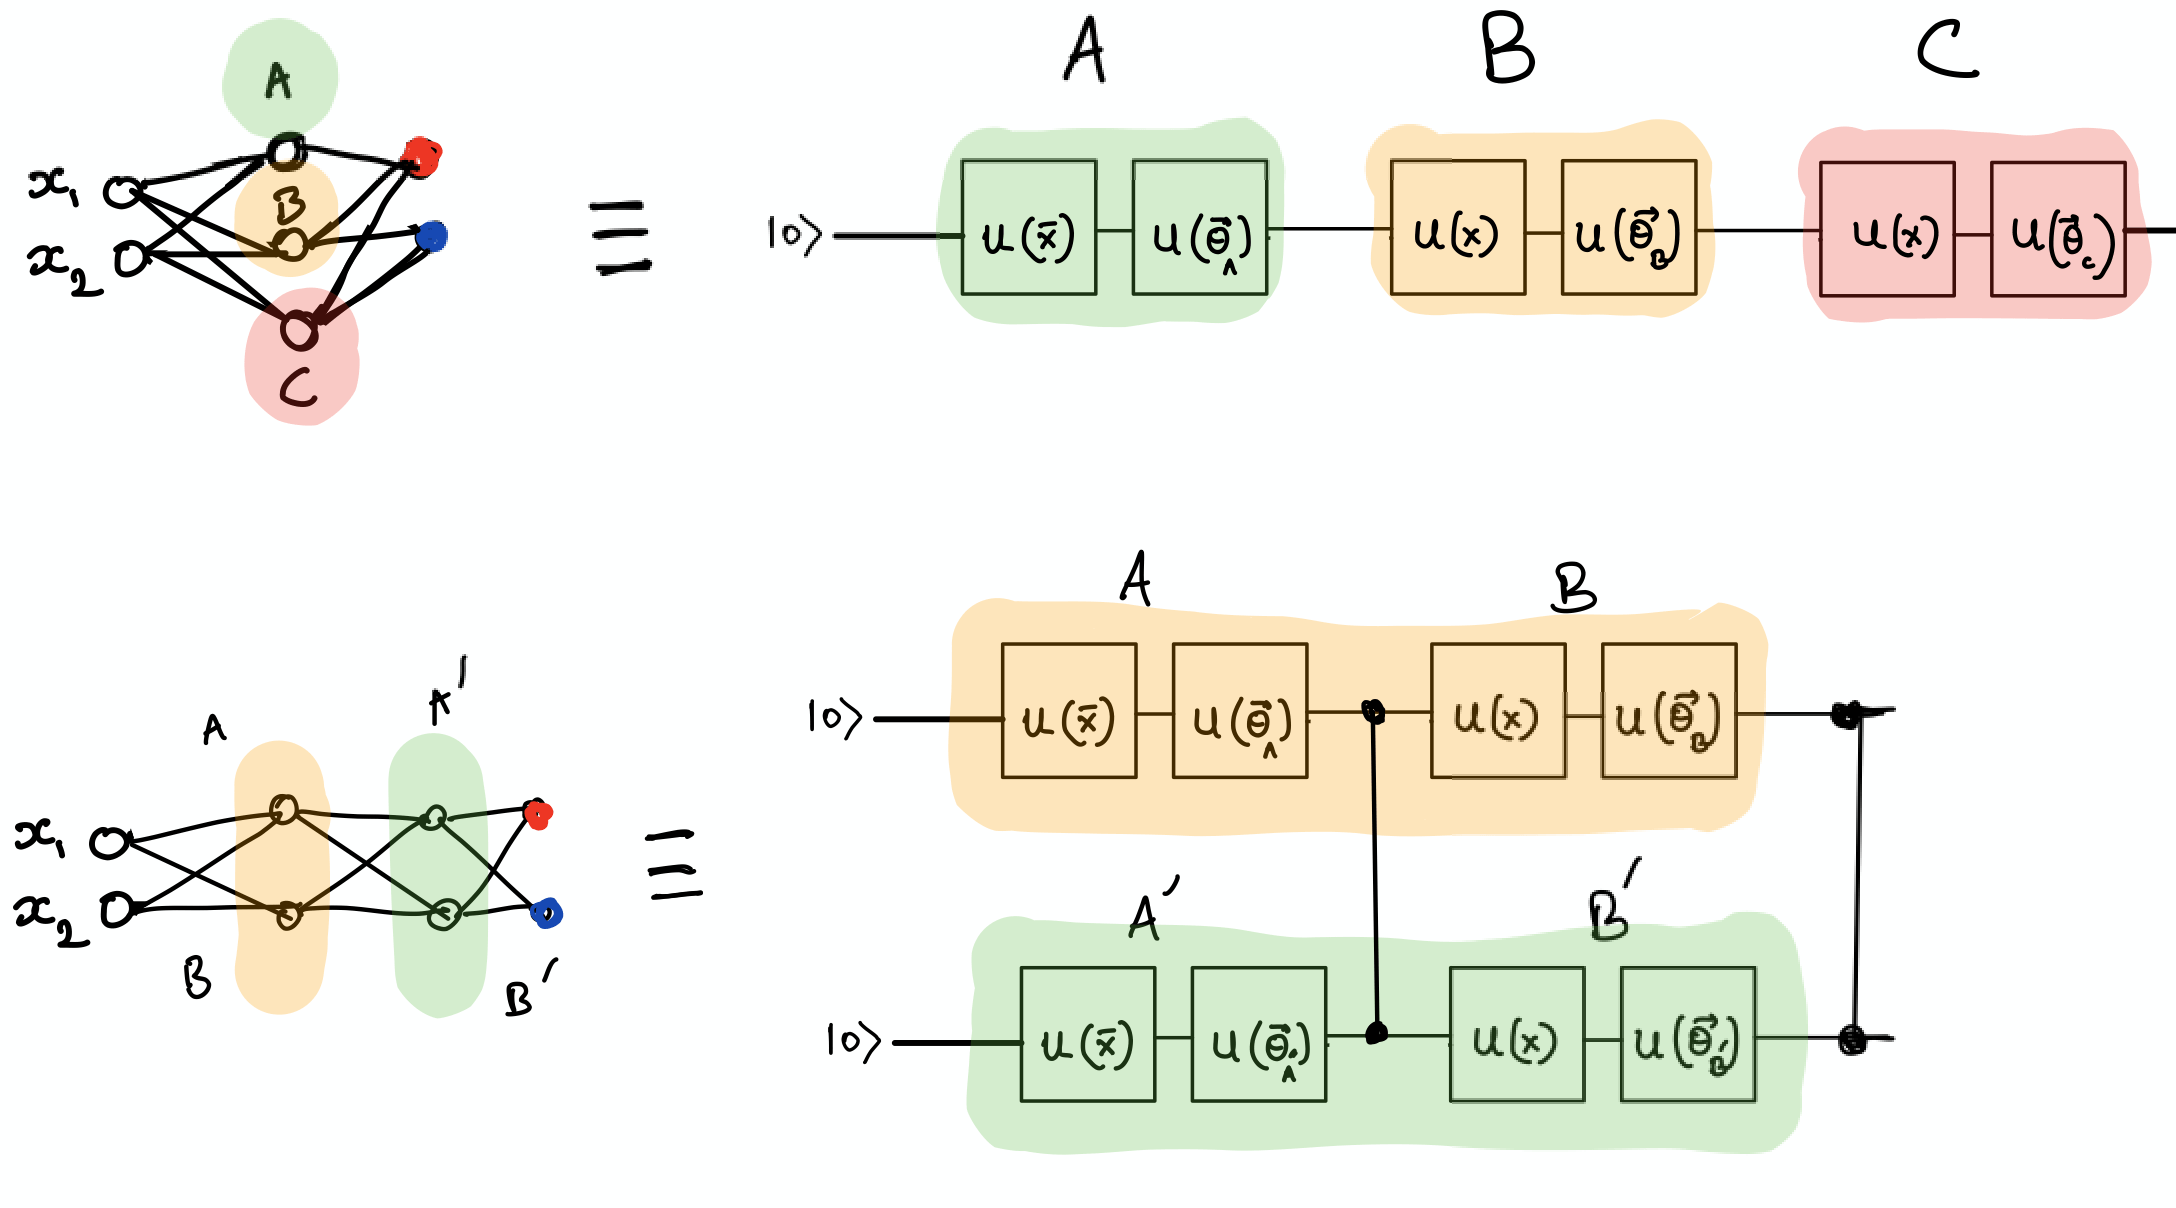

In [ ]:
class qml_model(nn.Module):
    def __init__(self, num_qubit, num_layer, nqe_model=None, data_reuploading=True):
        """
            nun_qubit(int) : 사용할 qubit 개수
            num_layer(int) : QML 모델이 반복할 총 layer의 횟수 (quantum layer 개수)
            nqe_model(RNNQE) : 사용할 NQE 객체
            data_reuploading(bool) : data reuploading 여부
        """
        super(qml_model, self).__init__()

        ## Instance Initialize ##
        self.num_qubit = num_qubit
        self.num_layer = num_layer
        self.data_reuploading = data_reuploading
        self.nqe = nqe_model

        ## Parameter Generation ##
        self.required_parameters = 3 * self.num_qubit * num_layer
        self.theta = nn.Parameter(
            torch.rand(self.required_parameters) * 2 * torch.pi, requires_grad=True
        )  # parameter 초기화 시 범위(0 ~ 2 * pi?) 적용

        ## Quantum Device Initialize ##
        self.device = qml.device("default.qubit", wires=num_qubit)
    
    def get_angles(self, sequenced_input):
        """
            TODO :
                sequenced input을 받아 Angle로 변환하여, self의 instance로 저장 및 return
            Args :
                sequenced_input(torch.tensor) : input(feature)의 sequence, shape : (batch, seq_len, feature_size)
        """
        if not self.nqe:
            last_sequence = sequenced_input[:, -1, :]  # Shape: (64, n)
            first_n = last_sequence.clone()
            phi_values = (torch.pi - last_sequence[:, :-1]) * (torch.pi - last_sequence[:, 1:])
            processed_data = torch.cat([first_n, phi_values], dim=1)
            return processed_data
        
        nqe_result = self.nqe.forward_input_RNN(sequenced_input)
        self.upload_angle = nqe_result
        return self.upload_angle
    
    def data_upload(self, angles):
        """
            TODO :
                sequenced input에 대해 변환된 Angle을 받아,, ZZ feature map으로 Embedding하는 회로에 적용
            Args :
                angles(torch.tensor) : sequenced_input에 대해 생성된 angles, shape : (batch, 2 * feature size - 1)
        """
        n = self.num_qubit

        ## Single Qubit Gates ##
        for i in range(n):
            qml.Hadamard(wires=i)
            qml.RZ(2.0 * angles[ : , i], i)
        
        ## Two Qubit Gates ##
        for i in range(n - 1):
            qml.IsingZZ(2.0 * angles[ : , n + i] , [i, i + 1])

    def unit_layer(self, theta, fully_entangle=False):
        """
            TODO : 
                RX RY RZ CNOT으로 이루어진 단위 layer
            Args :
                theta(list or tensor) : 1개의 layer에 대한 (3 * num_qubit)개의 parameter set
                fully_entangle(bool) : True -> last qubit과 first qubit에까지 CNOT을 적용
        """
        for i in range(self.num_qubit):
            qml.RX(theta[3 * i], wires=i)
            qml.RY(theta[3 * i + 1], wires=i)
            qml.RZ(theta[3 * i + 2], wires=i)

        for i in range(self.num_qubit - 1):
            qml.CNOT(wires=[i, i + 1])
        if fully_entangle:
            qml.CNOT(wires=[self.num_qubit - 1, 0])
    
    def outer_forward(self, sequenced_input):
        """
            TODO
                1. sequenced_input에 대한 NQE 결과, 즉 angle을 저장
                2. num_layer만큼 layer를 반복하여, data reuploading과 ansatz 적용(ansatz에 self.theta 사용)
                3. Measure (qml.expval)
            Args
                sequenced_input(tensor) : sequenced_input(torch.tensor) : input(feature)의 sequence, shape : (batch, seq_len, feature_size)
        """
        ## Get NQE Result ##
        nqe_result = self.get_angles(sequenced_input=sequenced_input)

        ## Layer Iteration ##
        for i in range(self.num_layer):
            ## Data Reuploading ##
            self.data_upload(nqe_result)
            qml.Barrier()

            ## Ansatz ##
            self.unit_layer(theta=self.theta[i * (3 * self.num_qubit) : (i + 1) * (3 * self.num_qubit)])
            qml.Barrier()
        return qml.expval(qml.PauliZ(0))

    def forward(self, sequenced_input, chk=False):
        """
            TODO :

            Args :
                sequenced_input(torch.tensor) : features with sequence, shape : (batch, seq_len, feature_size)
        """
        @qml.qnode(self.device)
        def inner_forward(input):
            result = self.outer_forward(sequenced_input=input)
            return result
        
        if chk:
            qml.draw_mpl(inner_forward, style="pennylane")(sequenced_input)
            return
        
        output = inner_forward(input=sequenced_input)
        output = output.reshape(-1, 1) # ??
        return output.float()  # -1 ~ 1까지만의 value 가질 수 있음

In [4]:
dp = data_prepare()
train_loader, test_loader = dp.train_test_dataloader(for_nqe=False, len_sequence=8, chk=False)
epochs = 250

/Users/jhan/Desktop/Ajou Univ/NonCurriculum/2024-winter/QuantumBreak/Study/0122_RNN_NQE/NQE/data_prepare.py:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  feature_tensor = torch.tensor(sequenced_feature_list, dtype=torch.float32)


In [5]:
def criterion(pred, label, bce=nn.BCELoss()):
    pred = (pred + 1) / 2
    label = (label + 1) / 2
    return bce(pred, label)

## Test 1

1 Layer

In [8]:
test1_qml_nqe = qml_model(5, 1, nqe)
test1_qml_none = qml_model(5, 1)
test1_trainer_nqe = trainer(test1_qml_nqe, train_loader, test_loader, criterion)
test1_trainer_none = trainer(test1_qml_none, train_loader, test_loader, criterion)

batch_size : 64


  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [01:57<00:00,  2.12it/s]


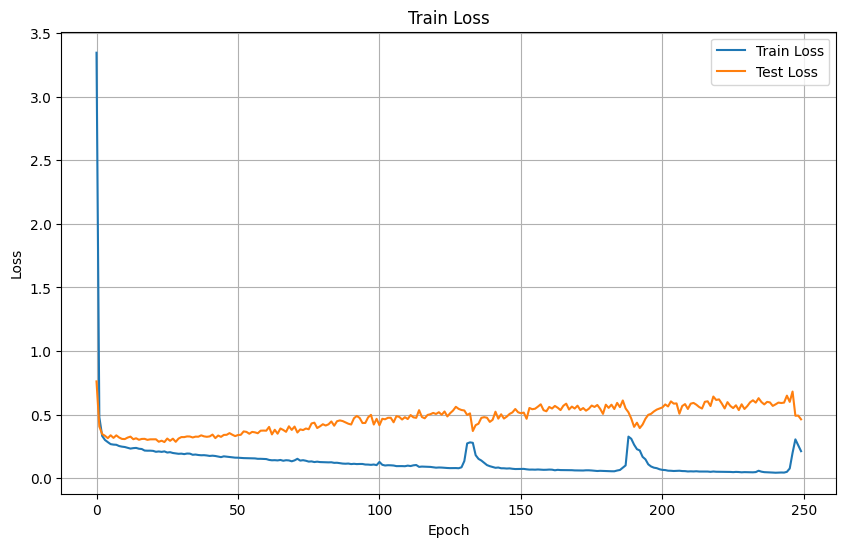

train loss : tensor(0.2126, grad_fn=<DivBackward0>)
test loss : tensor(0.4631, grad_fn=<DivBackward0>)


In [ ]:
test1_trainer_nqe.train(epochs, chk=True)
print('train loss :', test1_trainer_nqe.train_loss_list[-1])
print('test loss :', test1_trainer_nqe.test_loss_list[-1])
torch.save(test1_qml_nqe, "../models/nqe_qml_layer1.pt")

batch_size : 64


100%|██████████| 250/250 [01:17<00:00,  3.21it/s]


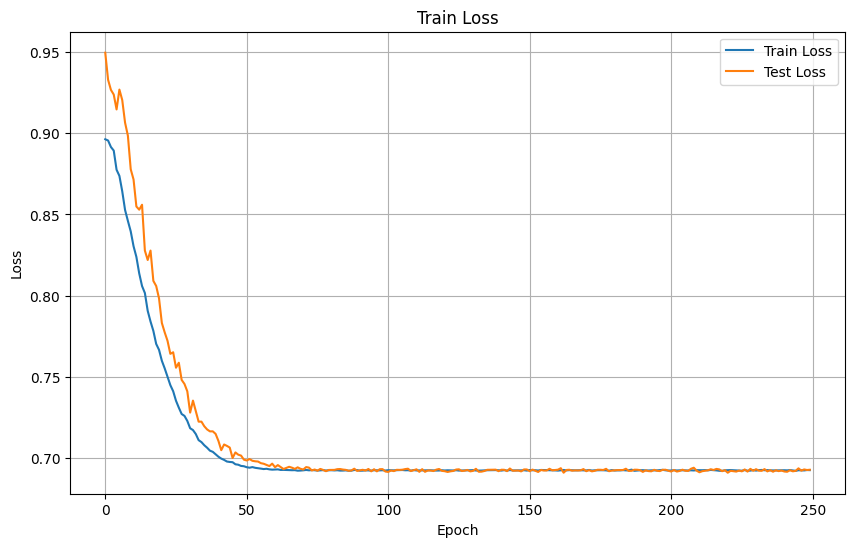

train loss : tensor(0.6924, grad_fn=<DivBackward0>)
test loss : tensor(0.6926, grad_fn=<DivBackward0>)


In [ ]:
test1_trainer_none.train(epochs, chk=True)
print('train loss :', test1_trainer_none.train_loss_list[-1])
print('test loss :', test1_trainer_none.test_loss_list[-1])
torch.save(test1_qml_none, "../models/none_qml_layer1.pt")

---

## Test 2

- 2 Layers

In [6]:
test2_qml_nqe = qml_model(5, 2, nqe)
test2_qml_none = qml_model(5, 2)
test2_trainer_nqe = trainer(test2_qml_nqe, train_loader, test_loader, criterion)
test2_trainer_none = trainer(test2_qml_none, train_loader, test_loader, criterion)

batch_size : 64


100%|██████████| 250/250 [03:20<00:00,  1.25it/s]


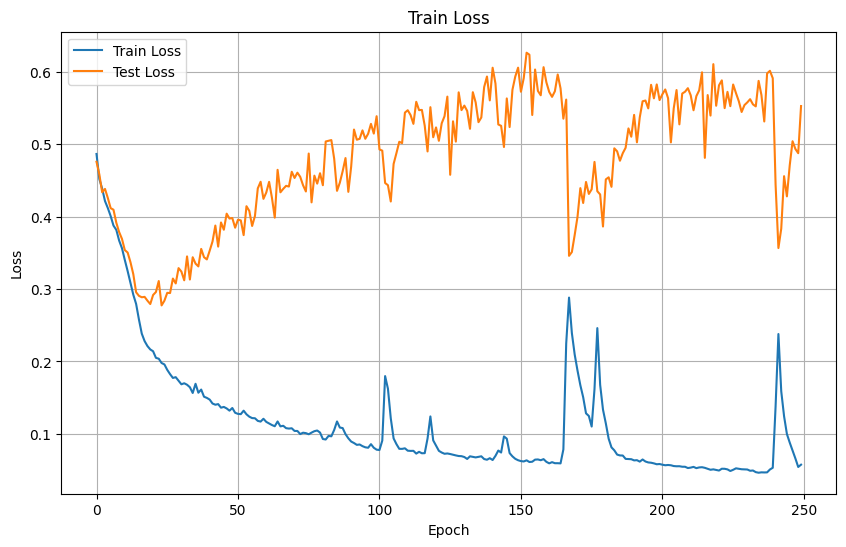

train loss : tensor(0.0573, grad_fn=<DivBackward0>)
test loss : tensor(0.5528, grad_fn=<DivBackward0>)


In [ ]:
test2_trainer_nqe.train(epochs, chk=True)
print('train loss :', test2_trainer_nqe.train_loss_list[-1])
print('test loss :', test2_trainer_nqe.test_loss_list[-1])
torch.save(test2_qml_nqe, "../models/nqe_qml_layer2.pt")

batch_size : 64


100%|██████████| 250/250 [02:56<00:00,  1.42it/s]


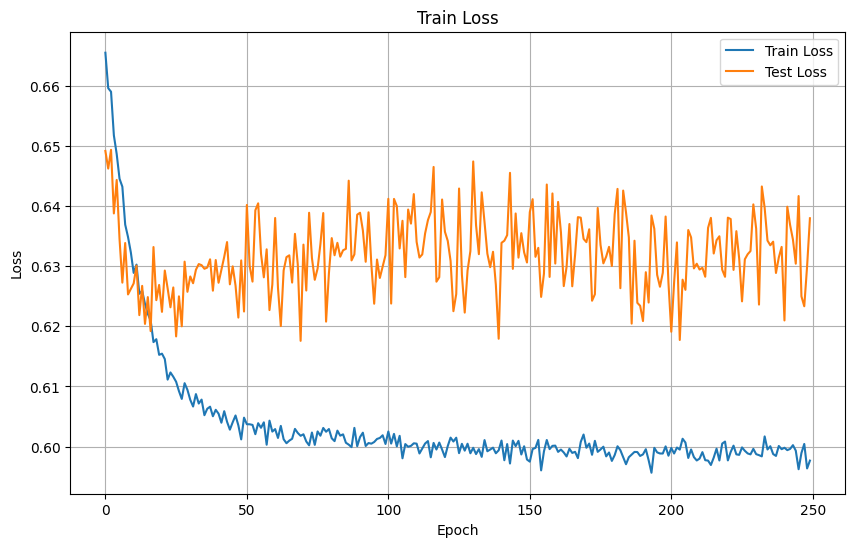

train loss : tensor(0.5977, grad_fn=<DivBackward0>)
test loss : tensor(0.6380, grad_fn=<DivBackward0>)


In [ ]:
test2_trainer_none.train(epochs, chk=True)
print('train loss :', test2_trainer_none.train_loss_list[-1])
print('test loss :', test2_trainer_none.test_loss_list[-1])
torch.save(test2_qml_none, "../models/none_qml_layer2.pt")

## Test 3

- layer 3

In [6]:
test3_qml_nqe = qml_model(5, 3, nqe)
test3_qml_none = qml_model(5, 3)
test3_trainer_nqe = trainer(test3_qml_nqe, train_loader, test_loader, criterion)
test3_trainer_none = trainer(test3_qml_none, train_loader, test_loader, criterion)

batch_size : 64


100%|██████████| 250/250 [04:57<00:00,  1.19s/it]


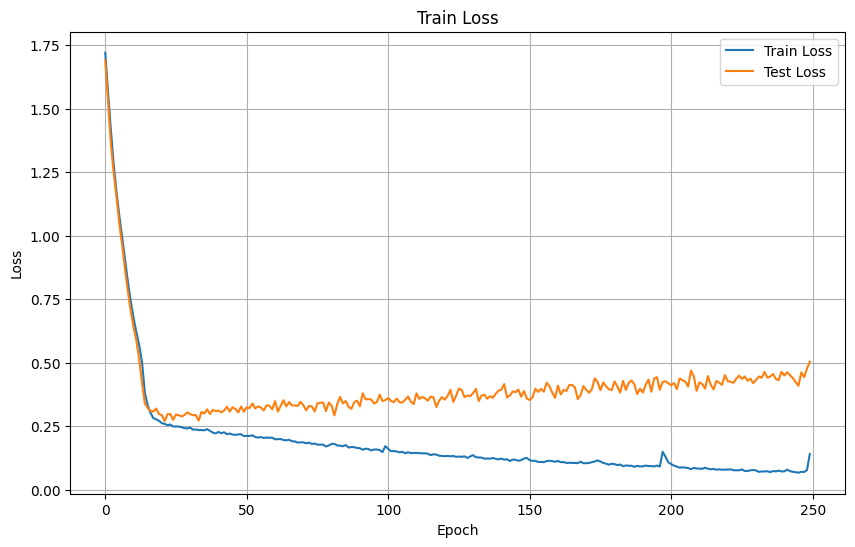

train loss : tensor(0.1408, grad_fn=<DivBackward0>)
test loss : tensor(0.5043, grad_fn=<DivBackward0>)


In [ ]:
test3_trainer_nqe.train(epochs, chk=True)
print('train loss :', test3_trainer_nqe.train_loss_list[-1])
print('test loss :', test3_trainer_nqe.test_loss_list[-1])
torch.save(test3_qml_nqe, "../models/nqe_qml_layer3.pt")

batch_size : 64


100%|██████████| 250/250 [03:40<00:00,  1.13it/s]


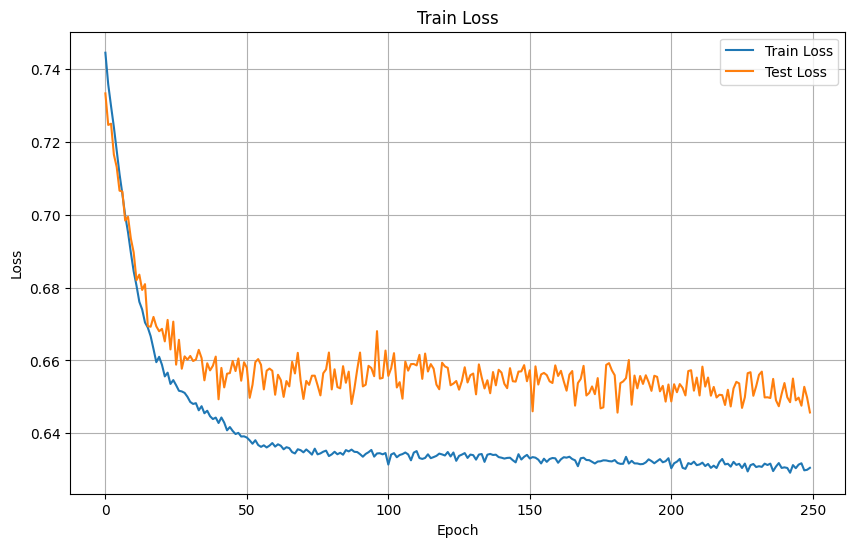

train loss : tensor(0.6306, grad_fn=<DivBackward0>)
test loss : tensor(0.6457, grad_fn=<DivBackward0>)


In [ ]:
test3_trainer_none.train(epochs, chk=True)
print('train loss :', test3_trainer_none.train_loss_list[-1])
print('test loss :', test3_trainer_none.test_loss_list[-1])
torch.save(test3_qml_none, "../models/none_qml_layer3.pt")

---

## Test 4

4 Layer

In [ ]:
test4_qml_nqe = qml_model(5, 4, nqe)
test4_qml_none = qml_model(5, 4)
test4_trainer_nqe = trainer(test4_qml_nqe, train_loader, test_loader, criterion)
test4_trainer_none = trainer(test4_qml_none, train_loader, test_loader, criterion)

batch_size : 64


100%|██████████| 250/250 [06:15<00:00,  1.50s/it]


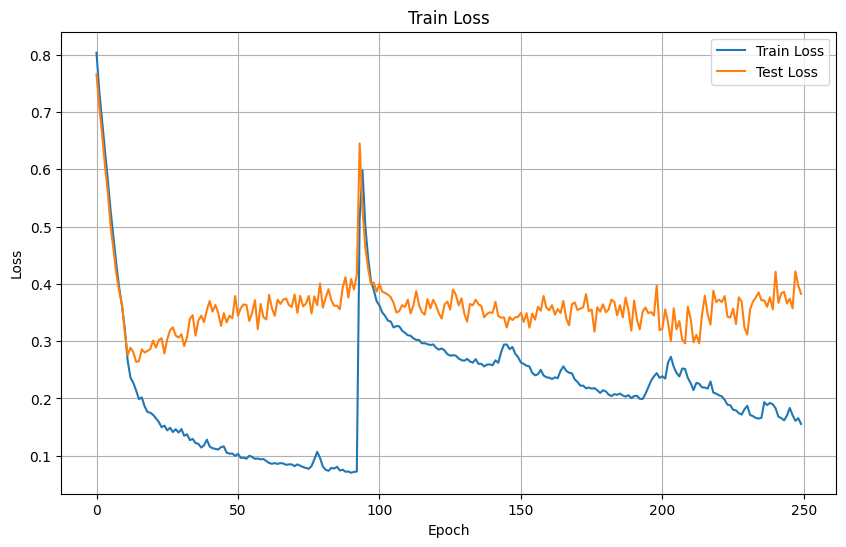

train loss : tensor(0.1556, grad_fn=<DivBackward0>)
test loss : tensor(0.3828, grad_fn=<DivBackward0>)


In [ ]:
test4_trainer_nqe.train(epochs, chk=True)
print('train loss :', test4_trainer_nqe.train_loss_list[-1])
print('test loss :', test4_trainer_nqe.test_loss_list[-1])
torch.save(test4_qml_nqe, "../models/nqe_qml_layer4.pt")

batch_size : 64


100%|██████████| 250/250 [04:57<00:00,  1.19s/it]


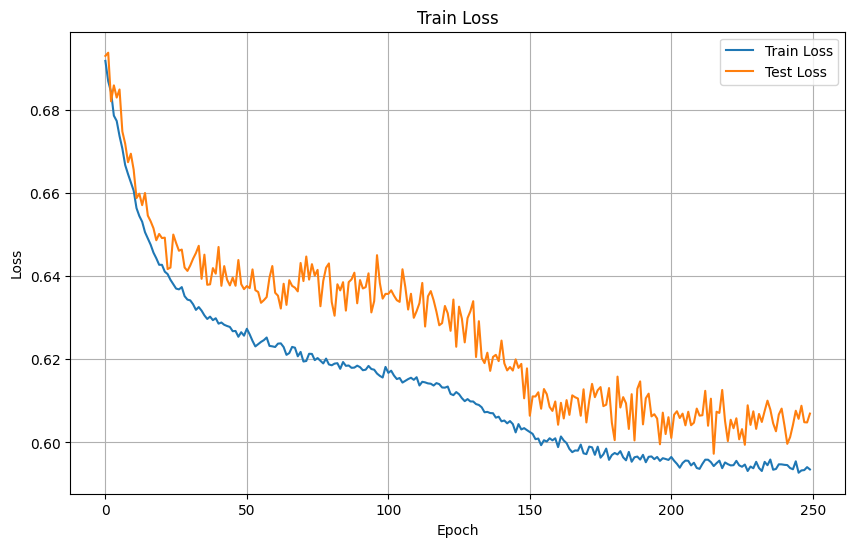

train loss : tensor(0.5935, grad_fn=<DivBackward0>)
test loss : tensor(0.6069, grad_fn=<DivBackward0>)


In [ ]:
test4_trainer_none.train(epochs, chk=True)
print('train loss :', test4_trainer_none.train_loss_list[-1])
print('test loss :', test4_trainer_none.test_loss_list[-1])
torch.save(test4_qml_none, "../models/none_qml_layer4.pt")

---